## Business Understanding

Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. Waterpoints are an invaluable source of water for household needs such as drinking and washing. These are strategically situated to help rural communities and given their importance, need to be constantly available for the communities. There are many waterpoints already established in the country, however, some are in need of repair while others have failed altogether. 

The primary task of this notebook is to predict the condition of a water well, given detailed information about the pumps. Ultimately, we will create a machine learning model to accurately determine contributing factors that can preemptively determine pump repair and/or failure. Knowing and addressing the most important factors are upkept will ensure pumps continue to provide clean water to people in Tanzania.

This information will prove useful to the entity responsible for the upkeep and maintenance of such waterpoints, as well as external donors that may be funding the operational costs associated with the equipment.

## Data Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# training_values.csv = features/dimensions we will be examining
# training_labels.csv = condition of the waterpoint 

training_values = pd.read_csv('training_values.csv')
training_labels = pd.read_csv('training_labels.csv')

In [2]:
# join the two dataframes on the id so we can match the correct condition to the correct waterpoint
df = training_values.set_index('id').join(training_labels.set_index('id'), how='inner')
df.reset_index(inplace=True)

In [3]:
display(df.head())
display(df.info())

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

None

> **Observations:** We will need to strategically reduce the current number of features, using domain knowledge and machine learning methods. Detailed information about what each feature means is defined in the `feature_descriptions.txt` data dictionary. We will examine the specific value counts for each column, shortly.

In [4]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


> **Observations:** `amount_tsh` (amount of water available to waterpoint) appears to have an outlier(s) as the _max_ values is significantly higher than the _mean_. We have no information on the interpretation of `num_private`, but has values from 0 to 1776, which is a signficant range. We also see 0 values for `construction_year`, which means we'll have to take that into consideration when dealing with missing/null values.

In [5]:
# obtain normalized value counts for each column
for col in df.columns:
    print(" ")
    print(f'---{col}---')
    print(df[col].value_counts())

 
---id---
2047     1
72310    1
49805    1
51852    1
62091    1
        ..
46396    1
36155    1
34106    1
38200    1
0        1
Name: id, Length: 59400, dtype: int64
 
---amount_tsh---
0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64
 
---date_recorded---
2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2012-01-25      1
2004-04-05      1
2004-07-01      1
2011-09-28      1
2011-09-12      1
Name: date_recorded, Length: 356, dtype: int64
 
---funder---
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Hashi                        1
Uniceg                       1
Piusi                        1
Omar Rafa

Name: source, dtype: int64
 
---source_type---
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64
 
---source_class---
groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64
 
---waterpoint_type---
communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
 
---waterpoint_type_group---
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64
 
---status_group---
functional    

> **Observations:** These results provide a great starting point in which features might be heavily correlated with one another or present similar data, like:
- `longitude`/`latitude` and `subvillage` and `region` and `region_code` and `district_code` and `lga/ward`
- `scheme_management` and `scheme_name`
- `extraction_type` and `extraction_type_group` and `extraction_type_class`
- `management` and `management_group`
- `water_quality` and `quality_group`
- `quantity` and `quantity_group`
- `source` and `source_type` and `source_class`
- `waterpoint_type` and `waterpoint_type_group`
- `payment` and `payment_type`

> These datapoints don't have any relevance or impact on the functionality of the wellpoint:
- `id`
- `wpt_name`
- `recorded_by` (same value for all datapoints)

> As we do not understand the feature description for `num_private` or `public_meeting` - it will be excluded from further analaysis.

> It also provides the three labels with which we will categorize the waterpoints:
- `functional`
- `non functional`
- `functional needs repair`

In [6]:
# examine dataset for NaN values
df.isna().sum()

# data.isna().any().any()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [7]:
# check original dataframe for duplicate values by unique `id` and `construction_year`
df[df.duplicated(['id','construction_year'])]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group


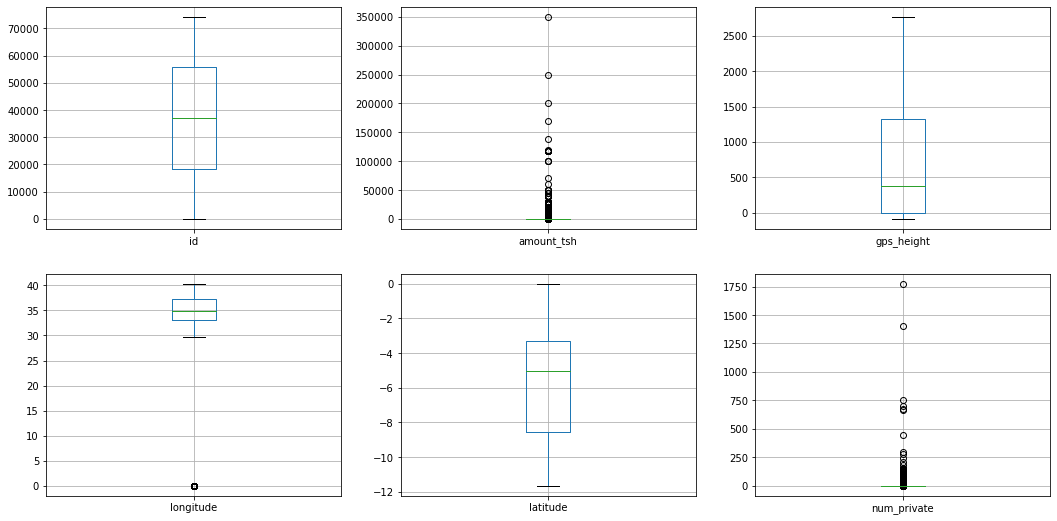

In [8]:
# create a boxplot to look for outliers (remove non-applicable columns)
cols = [col for col in df.columns if df[col].dtype != 'O']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,9))
for xcol, ax in zip(cols, axes.flatten()):
    boxplot = df.boxplot(column=xcol, ax=ax)

In [9]:
# examine outliers in further detail
display(df[df.amount_tsh >= 190000])
display(df[df.population >= 20000]) 

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
10812,41564,350000.0,2013-03-01,NaN,1558,NaN,34.840029,-4.542934,Mtinko Primary,0,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
22191,4128,250000.0,2011-03-04,Ded,285,WU,38.410852,-6.117538,Miono Dispensary,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
22817,7860,200000.0,2011-08-08,Government Of Tanzania,98,Government,38.978067,-5.122702,Shuleni,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
30537,12169,0.0,2011-03-12,Government Of Tanzania,184,DWE,38.783756,-5.181904,Mkwajuni,0,...,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


> **Observation**: None of the datapoints look like it was incorrectly entered and make reasonable sense. We'll include these outliers for now and determine at a later time, if removing them aids in model accuracy. Additionally, these waterpoints could be geographically positioned in a place with a large basin. Also populations tend to congregate, so it is not unreasonable to have outliers in available water at certain waterpoints or large populations.

In [10]:
# slice relevant features for data analysis
selected_features = ['amount_tsh', 'date_recorded', 'longitude', 'latitude', 'funder', 'gps_height', 'installer', 
                     'basin', 'region', 'population', 'scheme_management', 'permit', 'construction_year', 
                     'extraction_type_class', 'management', 'payment_type', 'quality_group', 'quantity_group', 
                     'waterpoint_type_group', 'lga', 'ward', 'extraction_type', 'subvillage', 'source', 
                     'source_type', 'source_class', 'waterpoint_type', 'quantity', 'water_quality', 'payment', 
                     'management_group','extraction_type_group', 'public_meeting', 'district_code', 'region_code',
                     'status_group']

In [11]:
# df.funder = df.funder.fillna("unknown")
# df.installer = df.installer.fillna("unknown")
# df.scheme_management = df.scheme_management.fillna("unknown")
# df.permit = df.permit.fillna("unknown")
# df.subvillage = df.subvillage.fillna("unknown")
# df.public_meeting = df.public_meeting.fillna("unknown")
# df.scheme_name = df.scheme_name.fillna("unknown")

In [12]:
# create function to reduce values in a column
def feature_reduction(df, column):
#     df[column] = df[column].fillna("unknown")
    
    x = 0
    selection = 0
    # determine the values that encapsulate the top 95% of the data
    while selection < 0.95:
        x += 1
        selection = df[column].value_counts(normalize=True)[:x].values.sum()   
    
    # replace the values of the 5% with placeholder of "other"
    selected_values = df[column].value_counts(normalize=True)[:x].index
    df.loc[~df[column].isin(selected_values), column] = "other"

In [13]:
# fill in NaN values with placeholders
feature_list = ['installer', 'funder', 'lga', 'ward', 'subvillage']

for col in feature_list:
    feature_reduction(df,col)

## Data Preparation

In [14]:
def data_preparation(df, selected_features):
    
    # use selected features for analysis
    data = df[selected_features]
    
    # for unknown construction years, set the values as actual NaN values
    # and set the median for the missing data
#     data.construction_year = data.construction_year.replace(0, np.nan).fillna(data.construction_year.median())

    # remove NaN rows for which construction year is unknown
    # data.dropna(subset= ['construction_year'], inplace=True)

    # convert every data value to a string, if the feature column is an object datatype
    for col in data.columns:
        if data[col].dtype == 'O':
            data.loc[:, col] = data[col].apply(str)
    
    features = data.drop('status_group', axis=1)
    labels = data.status_group

    return features, labels

In [15]:
def one_hot_encode(train_set, test_set, features):    
    # OneHotEncode categorical variables and create dataframe of features
    cat_features = [col for col in features.columns if features[col].dtype in [np.object]]
    X_train_cat = train_set.loc[:, cat_features]
    X_test_cat = test_set.loc[:, cat_features]

    ohe = OneHotEncoder(handle_unknown = 'ignore')
    
    X_train_ohe = ohe.fit_transform(X_train_cat)
    X_test_ohe = ohe.transform(X_test_cat)

    columns = ohe.get_feature_names(input_features=X_train_cat.columns)
    ohe_X_train = pd.DataFrame(X_train_ohe.todense(), columns=columns, index=train_set.index)
    ohe_X_test = pd.DataFrame(X_test_ohe.todense(), columns=columns, index=test_set.index)
    
    return ohe_X_train, ohe_X_test

In [16]:
# preprocess the training data
features, labels = data_preparation(df, selected_features)

In [17]:
# split into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=73)

In [18]:
# OneHotEncode training and validation sets
ohe_X_train, ohe_X_test = one_hot_encode(X_train, X_test, features)

## Modeling

### DRY function to train different models

In [19]:
# create function to train models
def model_train(model, grid):
    # construct a pipeline
    pipe = Pipeline([('ss', StandardScaler()),
                    ('model', model)])

    # Define a grid search
    gridsearch = GridSearchCV(estimator=pipe, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=3)

    # Fit the pipelines
    gridsearch.fit(ohe_X_train, y_train)

    best_parameters = gridsearch.best_params_

    print("Grid Search found the following optimal parameters: ")
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))

    # Print the accuracy on test set
    print(f'pipeline test accuracy:{gridsearch.score(ohe_X_test, y_test) :.2%}')
    
    return gridsearch

### Create baseline model

In [21]:
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')
model_log = logreg.fit(ohe_X_train, y_train)

# print the accuracy on test set
print(f'pipeline test accuracy:{model_log.score(ohe_X_test, y_test) :.2%}')

pipeline test accuracy:78.34%


### RandomForest with hyperparameter tuning

In [20]:
model = RandomForestClassifier(random_state=73)
# grid = [{'model__n_estimators': [10, 30, 100, 200],
#          'model__criterion': ['gini', 'entropy'],
#          'model__max_depth': [None, 2, 6, 10],
#          'model__min_samples_split': [2, 5, 10],
#          'model__min_samples_leaf': [1, 3, 6]}]
grid = [{'model__n_estimators': [200],
         'model__criterion': ['entropy'],
         'model__max_depth': [None],
         'model__min_samples_split': [10],
         'model__min_samples_leaf': [1]}]
model_rfc = model_train(model, grid)

Grid Search found the following optimal parameters: 
model__criterion: 'entropy'
model__max_depth: None
model__min_samples_leaf: 1
model__min_samples_split: 10
model__n_estimators: 200
pipeline test accuracy:81.00%


# Other models

### Logistic Regression with hyperparameter tuning

In [ ]:
model = LogisticRegression(random_state=73)
grid = [{'model__C': np.logspace(-4, 4, 50), 
         'model__penalty': ['l1', 'l2']}]

model_log = model_train(model, grid)

### Logistic Regression with Principal Component Analysis (dimensionality reduction)

In [ ]:
# determine the number of principal components to explain 95% of the variance
pca = PCA()
pca.fit_transform(ohe_X_train)

# determine the number of features to capture 95% of the variance
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = ohe_X_train.shape[1] - n_over_95 + 1
print("Number features: {}\tTotal Variance Explained: {}".format(n_to_reach_95, total_explained_variance[n_to_reach_95-1]))

# subset the dataset to these principal components which capture 95% of the overall variance
# reproject the dataset into a lower-dimensional space using PCA
pca = PCA(n_components=n_to_reach_95)
X_pca_train = pca.fit_transform(ohe_X_train)
X_pca_test = pca.transform(ohe_X_test)

pca.explained_variance_ratio_.cumsum()[-1]
# #### refit a model on the compressed dataset ####
# clf = svm.SVC(gamma='auto')
# train_pca_acc = clf.score(X_pca_train, y_train)
# test_pca_acc = clf.score(X_pca_test, y_test)
# print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_pca_acc, test_pca_acc))

In [ ]:
# create a function to train a model with PCA
def model_train_pca(model, grid):
    # construct a pipeline
    pipe = Pipeline([('pca', PCA(n_components=403, random_state=73)),
                    ('model', model)])

    # Define a grid search
    gridsearch = GridSearchCV(estimator=pipe, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=3)

    # Fit the pipelines
    gridsearch.fit(X_pca_train, y_train)

    best_parameters = gridsearch.best_params_

    print("Grid Search found the following optimal parameters: ")
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))

    # Print the accuracy on test set
    print(f'pipeline test accuracy:{gridsearch.score(X_pca_test, y_test) :.2%}')
    
    return gridsearch

model = LogisticRegression(random_state=73)
grid = [{'model__C': np.logspace(-4, 4, 50), 
         'model__penalty': ['l1', 'l2']}]

model_log = model_train_pca(model, grid)

### K-Neighbors with hyperparameter tuning

In [ ]:
model = KNeighborsClassifier()
# grid = [{'model__n_neighbors': [11, 19],
#          'model__weights': ['uniform', 'distance'],
#          'model__metric': ['euclidean', 'manhattan']}]
grid = [{'model__n_neighbors': [5,11],
         'model__weights': ['uniform'],
         'model__metric': ['minkowski']}]

model_knn = model_train(model, grid)

### SVM with hyperparameter tuning

In [ ]:
model = SVC(random_state=73)
# grid = [{'model__C' : np.linspace(.1, 10, num=2),
#         'model__gamma' : np.linspace(10**-3, 5, num=2),
#         'model__kernel': ['linear','rbf', 'poly', 'sigmoid']}]
grid = [{'model__C' : [1],
        'model__gamma' : ['scale'],
        'model__kernel': ['rbf']}]

model_svm = model_train(model, grid)

### DecisionTree with hyperparameter tuning

In [ ]:
model = DecisionTreeClassifier(random_state=73)
grid = [{'model__criterion': ['gini', 'entropy'],
         'model__max_depth': [None, 2, 3, 4, 5, 6],
         'model__min_samples_split': [2, 5, 10],
         'model__min_samples_leaf': [1, 2, 3, 4, 5, 6]}]

model_decisiontree = model_train(model, grid)

### AdaBoost with hyperparameter tuning

In [ ]:
model = AdaBoostClassifier(random_state=73)
grid = [{'model__n_estimators': [30, 50, 70],
         'model__learning_rate': [1.0, 0.5, 0.1]}]

model_adaboost = model_train(model, grid)

### XGBoost with hyperparameter tuning

In [ ]:
model = xgb.XGBClassifier(random_state=73)
grid = [{'model__learning_rate': [0.05, 0.1],
         'model__max_depth': [3, 6],
         'model__min_child_weight': [5, 10],
         'model__subsample': [0.3, 0.7],
         'model__n_estimators': [5, 30, 100, 250]}]

model_xgboost = model_train(model, grid)

### GradientBoosting with hyperparameter tuning

In [ ]:
model = GradientBoostingClassifier(random_state=73)
grid = [{'model__loss':["deviance"],
         'model__learning_rate': [0.01, 0.2],
         'model__min_samples_split': [0.1, 0.5],
         'model__min_samples_leaf': [0.1, 0.5],
         'model__max_depth':[3, 8],
         'model__max_features':["log2","sqrt"],
         'model__criterion': ["friedman_mse",  "mae"],
         'model__subsample':[0.5, 1.0],
         'model__n_estimators':[10]}]

model_gradientboosting = model_train(model, grid)

## Evaluation

### Final Model

After training various models and tuning hyperparameters, we see that the `RandomForest` classifier achieved the highest accuracy with a pipeline test accuracy of `81.00%`.

### Making Predictions

In [34]:
# import test data to be used for testing
test_df = pd.read_csv('testing_values.csv')

# remove labels from selected_features variable 
test_selected_features = selected_features.remove('status_group')

In [24]:
# # fill in NaN values with placeholders
# df.funder = df.funder.fillna("unknown")
# df.installer = df.installer.fillna("unknown")
# df.scheme_management = df.scheme_management.fillna("unknown")
# df.permit = df.permit.fillna("unknown")
# df.subvillage = df.subvillage.fillna("unknown")
# df.public_meeting = df.public_meeting.fillna("unknown")
# df.scheme_name = df.scheme_name.fillna("unknown")

In [35]:
# reduce the # of unique values in certain features using the function, "feature_reduction"
for col in feature_list:
    feature_reduction(test_df, col)

In [36]:
# create function to preprocess the test data
def test_data_preparation(df, selected_features):
    
    # use selected features for analysis
    data = df[selected_features]
    
#     # fill in relevant NaN values with placeholder value of 'unknown'
#     data.funder = data.funder.fillna("unknown")
#     data.installer = data.installer.fillna("unknown")
#     data.scheme_management = data.installer.fillna("unknown")
#     data.permit = data.permit.fillna("uknown")
    
    # for unknown construction years, set the values as actual NaN values
    # data[data.construction_year == 0] = np.nan
    # alternatively, we can set the median for the missing data: data.construction_year.fillna(data.construction_year.median())

    # remove NaN rows for which construction year is unknown
    # data.dropna(subset= ['construction_year'], inplace=True)

    # convert every data value to a string, if the feature column is an object datatype
    for col in data.columns:
        if data[col].dtype == 'O':
            data.loc[:, col] = data[col].apply(str)
    
    return data

In [37]:
# OneHotEncode categorical variables and create dataframe of test data features
def test_one_hot_encode(train_set, test_set):    
    
    cat_features = [col for col in features.columns if features[col].dtype in [np.object]]
    X_train_cat = train_set.loc[:, cat_features]
    X_test_cat = test_set.loc[:, cat_features]

    ohe = OneHotEncoder(handle_unknown = 'ignore')
    
    X_train_ohe = ohe.fit_transform(X_train_cat)
    X_test_ohe = ohe.transform(X_test_cat)

    columns = ohe.get_feature_names(input_features=X_train_cat.columns)
    ohe_X_train = pd.DataFrame(X_train_ohe.todense(), columns=columns, index=train_set.index)
    ohe_X_test = pd.DataFrame(X_test_ohe.todense(), columns=columns, index=test_set.index)
    
    return ohe_X_train, ohe_X_test

In [38]:
# preprocess the test data
testing_data = test_data_preparation(test_df, selected_features)

In [39]:
# OneHotEncode the test data
ohe_X_training, ohe_X_testing = test_one_hot_encode(features, testing_data)

In [40]:
# retrain the final model on complete data set (training & validation)
pipe = Pipeline([('ss', StandardScaler()),
                 ('model', RandomForestClassifier(random_state=73))])

grid = [{'model__n_estimators': [200],
         'model__criterion': ['entropy'],
         'model__max_depth': [None],
         'model__min_samples_split': [10],
         'model__min_samples_leaf': [1]}]

# Define a grid search
final_model = GridSearchCV(estimator=pipe, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=3)

# Fit the pipelines
final_model.fit(ohe_X_training, labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('model',
                                        RandomForestClassifier(random_state=73))]),
             param_grid=[{'model__criterion': ['entropy'],
                          'model__max_depth': [None],
                          'model__min_samples_leaf': [1],
                          'model__min_samples_split': [10],
                          'model__n_estimators': [200]}],
             scoring='accuracy')

In [41]:
# predict the status group on the test data and create a list from it
results = list(final_model.predict(ohe_X_testing))

In [42]:
# export the results
status_groups = pd.DataFrame(results, columns=['status'])
status_groups.to_csv('results.csv', index=False)

Score results on drivendata.org:
<img src="drivendatascore.png">